In [14]:
TARGET_NODE = 32

probe_sample = 80

TARGET_STR = str(TARGET_NODE)

import argparse
import pickle
import traceback
import pytorch_lightning as pl
from pytorch_lightning.utilities import rank_zero_info
import models
import tasks
import utils.callbacks
import utils.data
import utils.email
import utils.logging
import torch
from matplotlib import pyplot as plt
import networkx as nx
import math
import time
import torch
import numpy as np
import pandas as pd
from scipy.special import softmax
from pgmpy.estimators.CITests import chi_square
from pgmpy.estimators import HillClimbSearch, BicScore
from pgmpy.models import BayesianModel, BayesianNetwork
from pgmpy.inference import VariableElimination
from scipy import stats

from pgmpy.estimators import HillClimbSearch, BicScore

def graph_from_adj(adjacency_matrix):
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)
    return gr
class Node_Explainer:
    def __init__(
        self,
        model,
        regressor,
        A,
        X,
        target,
        num_layers,
        mode = 0,
        print_result = 1
    ):
        self.model = model
        self.model.eval()
        self.regressor = regressor
        self.A = A
        self.X = X
        self.target = target
        self.num_layers = num_layers
        self.mode = mode
        self.print_result = print_result
        print("Explainer settings")
        print("\\ A dim: ", self.A.shape)
        print("\\ X dim: ", self.X.shape)
        print("\\ Number of layers: ", self.num_layers)
        print("\\ Perturbation mode: ", self.mode)
        print("\\ Print result: ", self.print_result)
    
    def n_hops_A(self, n_hops):
        # Compute the n-hops adjacency matrix
        adj = torch.tensor(self.A, dtype=torch.float)
        hop_adj = power_adj = adj
        for i in range(n_hops - 1):
            power_adj = power_adj @ adj
            prev_hop_adj = hop_adj
            hop_adj = hop_adj + power_adj
            hop_adj = (hop_adj > 0).float()
        return hop_adj.numpy().astype(int)
    
    def extract_n_hops_neighbors(self, nA, node_idx):
        # Return the n-hops neighbors of a node
        node_nA_row = nA[node_idx]
        neighbors = np.nonzero(node_nA_row)[0]
        node_idx_new = sum(node_nA_row[:node_idx])
        sub_A = self.A[neighbors][:, neighbors]
        sub_X = self.X[neighbors]
        return node_idx_new, sub_A, sub_X, neighbors
    
    def perturb_features_on_node_1d(self, feature_matrix, node_idx, random = 0, mode = 0):
        # return a random perturbed feature matrix
        # random = 0 for nothing, 1 for random.
        # mode = 0 for random 0-1, 1 for scaling with original feature
        
        X_perturb = feature_matrix
        if mode == 0:
            if random == 0:
                perturb_array = X_perturb[node_idx]
            elif random == 1:
                perturb_array = np.random.randint(2, size = 1)
            X_perturb[node_idx] = perturb_array
        elif mode == 1:
            if random == 0:
                perturb_array = X_perturb[node_idx]
            elif random == 1:
                perturb_array = np.multiply(X_perturb[node_idx], np.random.uniform(low=0.0, high=2.0, size = 1))
            X_perturb[node_idx] = perturb_array
        return X_perturb
    
    def perturb_features_on_node(self,feature_matrix, node_idx, random = 0, mode = 0):
        # return a random perturbed feature matrix
        # random = 0 for nothing, 1 for random.
        # mode = 0 for random 0-1, 1 for scaling with original feature
        
        X_perturb = feature_matrix
        if mode == 0:
            if random == 0:
                perturb_array = X_perturb[node_idx]
            elif random == 1:
                perturb_array = np.random.randint(2, size = X_perturb[node_idx].shape[0])
            X_perturb[node_idx] = perturb_array
        elif mode == 1:
            if random == 0:
                perturb_array = X_perturb[node_idx]
            elif random == 1:
                perturb_array = np.multiply(X_perturb[node_idx],np.random.uniform(low=0.0, high=2.0, size = X_perturb[node_idx].shape[0]))
            X_perturb[node_idx] = perturb_array
        return X_perturb
    
    def generalize_target(self, x):
        if x > 10:
            return x - 10
        else:
            return x

    def generalize_others(self, x):
        if x == 2:
            return 1
        elif x == 12:
            return 11
        else:
            return x

    def generate_evidence(self, evidence_list):
        return dict(zip(evidence_list,[1 for node in evidence_list]))
    
    def chi_square(self, X, Y, Z, data):
        """
        Modification of Chi-square conditional independence test from pgmpy
        Tests the null hypothesis that X is independent from Y given Zs.
        Parameters
        ----------
        X: int, string, hashable object
            A variable name contained in the data set
        Y: int, string, hashable object
            A variable name contained in the data set, different from X
        Zs: list of variable names
            A list of variable names contained in the data set, different from X and Y.
            This is the separating set that (potentially) makes X and Y independent.
            Default: []
        Returns
        -------
        chi2: float
            The chi2 test statistic.
        p_value: float
            The p_value, i.e. the probability of observing the computed chi2
            statistic (or an even higher value), given the null hypothesis
            that X _|_ Y | Zs.
        sufficient_data: bool
            A flag that indicates if the sample size is considered sufficient.
            As in [4], require at least 5 samples per parameter (on average).
            That is, the size of the data set must be greater than
            `5 * (c(X) - 1) * (c(Y) - 1) * prod([c(Z) for Z in Zs])`
            (c() denotes the variable cardinality).
        References
        ----------
        [1] Koller & Friedman, Probabilistic Graphical Models - Principles and Techniques, 2009
        Section 18.2.2.3 (page 789)
        [2] Neapolitan, Learning Bayesian Networks, Section 10.3 (page 600ff)
            http://www.cs.technion.ac.il/~dang/books/Learning%20Bayesian%20Networks(Neapolitan,%20Richard).pdf
        [3] Chi-square test https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test#Test_of_independence
        [4] Tsamardinos et al., The max-min hill-climbing BN structure learning algorithm, 2005, Section 4
        """
        if isinstance(X, int):
            X = str(int(X))
        if isinstance(Y, int):
            Y = str(int(Y))
        if isinstance(Z, (frozenset, list, set, tuple)):
            Z = list(Z)        
        Z = [str(int(z)) for z in Z]
            
        state_names = {
            var_name: data.loc[:, var_name].unique() for var_name in data.columns
        }
        
        row_index = state_names[X]
        column_index = pd.MultiIndex.from_product(
                [state_names[Y]] + [state_names[z] for z in Z], names=[Y] + Z
            )
        
        XYZ_state_counts = pd.crosstab(
                    index=data[X], columns= [data[Y]] + [data[z] for z in Z],
                    rownames=[X], colnames=[Y] + Z
                )

        if not isinstance(XYZ_state_counts.columns, pd.MultiIndex):
                XYZ_state_counts.columns = pd.MultiIndex.from_arrays([XYZ_state_counts.columns])
        XYZ_state_counts = XYZ_state_counts.reindex(
                index=row_index, columns=column_index
            ).fillna(0)
        
        if Z:
            XZ_state_counts = XYZ_state_counts.sum(axis=1,level = list( range(1,len(Z)+1)) )  # marginalize out Y
            YZ_state_counts = XYZ_state_counts.sum().unstack(Z)  # marginalize out X
        else:
            XZ_state_counts = XYZ_state_counts.sum(axis=1)
            YZ_state_counts = XYZ_state_counts.sum()
        Z_state_counts = YZ_state_counts.sum()  # marginalize out both
        
        XYZ_expected = np.zeros(XYZ_state_counts.shape)

        r_index = 0
        for X_val in XYZ_state_counts.index:
            X_val_array = []
            if Z:
                for Y_val in XYZ_state_counts.columns.levels[0]:
                    temp = XZ_state_counts.loc[X_val] * YZ_state_counts.loc[Y_val] / Z_state_counts
                    X_val_array = X_val_array + list(temp.to_numpy())
                XYZ_expected[r_index] = np.asarray(X_val_array)
                r_index=+1
            else:
                for Y_val in XYZ_state_counts.columns:
                    temp = XZ_state_counts.loc[X_val] * YZ_state_counts.loc[Y_val] / Z_state_counts
                    X_val_array = X_val_array + [temp]
                XYZ_expected[r_index] = np.asarray(X_val_array)
                r_index=+1
        
        observed = XYZ_state_counts.to_numpy().reshape(1,-1)
        expected = XYZ_expected.reshape(1,-1)
        observed, expected = zip(*((o, e) for o, e in zip(observed[0], expected[0]) if not (e == 0 or math.isnan(e) )))
        chi2, significance_level = stats.chisquare(observed, expected)

        return chi2, significance_level
    
    def explain_tgcn_node(self, 
                          node_idx, 
                          pred_threshold = 0.01, 
                          p_omega = 0.5, 
                          num_perturbations = 100, 
                          p_threshold = 0.01 ):
        
#           node_idx:  node to explain
#           pred_threshold: change in the softmax 
#           p_omega: perturbation probability
#           num_perturbations: number of perturbations 
#           p_threshold: p values for dependent neighbors 
        
        nA = self.n_hops_A(self.num_layers)
        node_idx_new, sub_A, sub_X, neighbors = self.extract_n_hops_neighbors(nA,node_idx)
        pred_output, _ = self.model.forward(self.X.unsqueeze(0))
        pred_output = pred_output.reshape((1, self.X.shape[0], -1))
        soft_pred = self.regressor.forward(pred_output)[0,:,self.target]

        Samples = []
        Pred_Samples = []
        
        pred_omega = int(1/p_omega)

        for iteration in range(num_perturbations):
            X_perturb = self.X.cpu().detach().numpy().copy()
            sample = []
            for node in neighbors:
                seed = np.random.randint(pred_omega)
                if seed == 1:
                    latent = 1
                    X_perturb = self.perturb_features_on_node_1d(X_perturb, node, random = seed, mode = 1)
                else:
                    latent = 0
                sample.append(latent)
            X_perturb_torch =  torch.tensor([X_perturb], dtype=torch.float)
            pred_perturb_torch, _ = self.model.forward(X_perturb_torch)
            pred_perturb_torch = pred_perturb_torch.reshape((1, self.X.shape[0], -1))
            soft_pred_perturb = self.regressor.forward(pred_perturb_torch)[0,:,self.target]
            sample_bool = []
            for node in neighbors:
                if torch.abs(soft_pred_perturb[node] - soft_pred[node]).item() > pred_threshold:
                    sample_bool.append(1)
                else:
                    sample_bool.append(0)
            Samples.append(sample)
            Pred_Samples.append(sample_bool)

        Samples = np.asarray(Samples)
        Pred_Samples = np.asarray(Pred_Samples)
        Combine_Samples = Samples-Samples
        for s in range(Samples.shape[0]):
            Combine_Samples[s] = np.asarray([Samples[s,i]*10 + Pred_Samples[s,i]+1 for i in range(Samples.shape[1])])

        data = pd.DataFrame(Combine_Samples)
        data.columns = ['var_' + str(col) for col in data.columns]
        ind_sub_to_ori = dict(zip(list(data.columns), neighbors))
        ind_ori_to_sub = dict(zip(neighbors,list(data.columns)))
    
        p_values = []
        dependent_neighbors = []
        dependent_neighbors_p_values = []
        for node in neighbors:

            chi2, p = self.chi_square(ind_ori_to_sub[node], ind_ori_to_sub[node_idx], [], data)
            p_values.append(p)
            if p < p_threshold:
                dependent_neighbors.append(node)
                dependent_neighbors_p_values.append(p)
        
        pgm_stats = dict(zip(neighbors,p_values))
  

        pgm_nodes = dependent_neighbors
        
        data = data.rename(columns={"A": 0, "B": 1})
        data = data.rename(columns=ind_sub_to_ori)
        
        return pgm_nodes, data, pgm_stats
    
    def pgm_generate(self, target, data, pgm_stats, subnodes, child = None):
   
        subnodes = [str(int(node)) for node in subnodes]
        target = str(int(target))
        subnodes_no_target = [node for node in subnodes if node != target]
        data.columns = data.columns.astype(str)
        
        MK_blanket = self.search_MK(data, target, subnodes_no_target.copy())
        

        if child == None:
#             est = HillClimbSearch(data[subnodes_no_target], scoring_method=BicScore(data))
            est = HillClimbSearch(data[subnodes_no_target])
            pgm_no_target = est.estimate(scoring_method=BicScore(data))
            for node in MK_blanket:
                if node != target:
                    pgm_no_target.add_edge(node,target)

        #   Create the pgm    
            pgm_explanation = BayesianModel()
            for node in pgm_no_target.nodes():
                pgm_explanation.add_node(node)
            for edge in pgm_no_target.edges():
                pgm_explanation.add_edge(edge[0],edge[1])

        #   Fit the pgm
            data_ex = data[subnodes].copy()
            data_ex[target] = data[target].apply(self.generalize_target)
            for node in subnodes_no_target:
                data_ex[node] = data[node].apply(self.generalize_others)
            pgm_explanation.fit(data_ex)
        else:
            data_ex = data[subnodes].copy()
            data_ex[target] = data[target].apply(self.generalize_target)
            for node in subnodes_no_target:
                data_ex[node] = data[node].apply(self.generalize_others)
                
#             est = HillClimbSearch(data_ex, scoring_method=BicScore(data_ex))
            est = HillClimbSearch(data_ex)
            pgm_w_target_explanation = est.estimate(scoring_method=BicScore(data))
            
            #   Create the pgm    
            pgm_explanation = BayesianModel()
            for node in pgm_w_target_explanation.nodes():
                pgm_explanation.add_node(node)
            for edge in pgm_w_target_explanation.edges():
                pgm_explanation.add_edge(edge[0],edge[1])

            #   Fit the pgm
            data_ex = data[subnodes].copy()
            data_ex[target] = data[target].apply(self.generalize_target)
            for node in subnodes_no_target:
                data_ex[node] = data[node].apply(self.generalize_others)
            pgm_explanation.fit(data_ex)
        

        return pgm_explanation
    
    def search_MK(self, data, target, nodes):
        target = str(int(target))
        data.columns = data.columns.astype(str)
        nodes = [str(int(node)) for node in nodes]
        
        MB = nodes
        while True:
            count = 0
            for node in nodes:
                evidences = MB.copy()
                evidences.remove(node)
                if target not in nodes:
                    _, p = self.chi_square(target, node, evidences, data[nodes + [target]])
                else:
                    _, p = self.chi_square(target, node, evidences, data[nodes])
                if p > 0.05:
                    MB.remove(node)
                    count = 0
                else:
                    count = count + 1
                    if count == len(MB):
                        return MB
    
    def generate_evidence(self, evidence_list):
        return dict(zip(evidence_list, [1 for node in evidence_list]))
                    
    def pgm_conditional_prob(self, target, pgm_explanation, evidence_list):
        pgm_infer = VariableElimination(pgm_explanation)
        for node in evidence_list:
            if node not in list(pgm_infer.model.nodes):
                print("Not valid evidence list.")
                return None
        evidences = self.generate_evidence(evidence_list)
        elimination_order = [node for node in list(pgm_infer.model.nodes) if node not in evidence_list]
        elimination_order = [node for node in elimination_order if node != target]
        q = pgm_infer.query([target], evidence = evidences,
                        elimination_order = elimination_order, show_progress=False)
        return q.values[0]

In [15]:



DATA_PATHS = {
    "shenzhen": {"feat": "data/sz_speed.csv", "adj": "data/sz_adj.csv"},
    "losloop": {"feat": "data/los_speed.csv", "adj": "data/los_adj.csv"},
}


def get_model(args, dm):
    model = None
    if args.model_name == "GCN":
        model = models.GCN(adj=dm.adj, input_dim=args.seq_len, output_dim=args.hidden_dim)
    if args.model_name == "GRU":
        model = models.GRU(input_dim=dm.adj.shape[0], hidden_dim=args.hidden_dim)
    if args.model_name == "TGCN":
        model = models.TGCN(adj=dm.adj, hidden_dim=args.hidden_dim)
    return model


def get_task(args, model, dm):
    task = getattr(tasks, args.settings.capitalize() + "ForecastTask")(
        model=model, feat_max_val=dm.feat_max_val, **vars(args)
    )
    return task


def get_callbacks(args):
    checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="train_loss")
    plot_validation_predictions_callback = utils.callbacks.PlotValidationPredictionsCallback(monitor="train_loss")
    callbacks = [
        checkpoint_callback,
        plot_validation_predictions_callback,
    ]
    return callbacks


def main_supervised(args):
    dm = utils.data.SpatioTemporalCSVDataModule(
        feat_path=DATA_PATHS[args.data]["feat"], adj_path=DATA_PATHS[args.data]["adj"], **vars(args)
    )
    model = get_model(args, dm)
    task = get_task(args, model, dm)
    callbacks = get_callbacks(args)
    trainer = pl.Trainer.from_argparse_args(args, callbacks=callbacks)
    trainer.fit(task, dm)
    results = trainer.validate(datamodule=dm)
    return results, model,task, dm  


def main(args):
    rank_zero_info(vars(args))
    results, model,task, dm = globals()["main_" + args.settings](args)
    return results, model,task, dm

In [16]:
parser = argparse.ArgumentParser()
#parser = pl.Trainer.add_argparse_args(parser)

parser.add_argument("--max_epochs", default = 10)
parser.add_argument("--pre_len", type=int, default=3)
parser.add_argument("--val_batch_size", type=int, default=1)
#parser.add_argument("--learning_rate", default = 0.001)
#parser.add_argument("--weight_decay", default = 0)
#parser.add_argument("--batch_size", default =  32)
#parser.add_argument("--hidden_dim", default = 64)
#parser.add_argument("--loss", default = "mse_with_regularizer") 
parser.add_argument("--gpus", default =  1) 


parser.add_argument(
    "--data", type=str, help="The name of the dataset", choices=("shenzhen", "losloop"), default="shenzhen"
)
parser.add_argument(
    "--model_name",
    type=str,
    help="The name of the model for spatiotemporal prediction",
    choices=("GCN", "GRU", "TGCN"),
    default="TGCN",
)
parser.add_argument(
    "--settings",
    type=str,
    help="The type of settings, e.g. supervised learning",
    choices=("supervised",),
    default="supervised",
)
parser.add_argument("--log_path", type=str, default=None, help="Path to the output console log file")
parser.add_argument("--send_email", "--email", action="store_true", help="Send email when finished")

temp_args, _ = parser.parse_known_args()

parser = getattr(utils.data, temp_args.settings.capitalize() + "DataModule").add_data_specific_arguments(parser)
parser = getattr(models, temp_args.model_name).add_model_specific_arguments(parser)
parser = getattr(tasks, temp_args.settings.capitalize() + "ForecastTask").add_task_specific_arguments(parser)

args = parser.parse_args("")
utils.logging.format_logger(pl._logger)
if args.log_path is not None:
    utils.logging.output_logger_to_file(pl._logger, args.log_path)

rank_zero_info(vars(args))
dm = utils.data.SpatioTemporalCSVDataModule(
    feat_path=DATA_PATHS[args.data]["feat"], adj_path=DATA_PATHS[args.data]["adj"], **vars(args)
)
model = get_model(args, dm)
task = get_task(args, model, dm)
callbacks = get_callbacks(args)
path = "model_tgcn.pt"
task.load_state_dict(torch.load(path))

dm.setup() # Generate train/val dataset
#results, model, task, dm = main(args)

# trainer = pl.Trainer.from_argparse_args(args, callbacks=callbacks)
# results = trainer.validate(task, datamodule=dm)

[2022-03-08 10:28:04,871 INFO]{'max_epochs': 10, 'pre_len': 3, 'val_batch_size': 1, 'gpus': 1, 'data': 'shenzhen', 'model_name': 'TGCN', 'settings': 'supervised', 'log_path': None, 'send_email': False, 'batch_size': 32, 'seq_len': 12, 'split_ratio': 0.8, 'normalize': True, 'hidden_dim': 64, 'learning_rate': 0.001, 'weight_decay': 0.0015, 'loss': 'mse_with_regularizer'}


In [17]:
#Clone regressor
#source_task: contain attributes model (TGCN) and regressor
#dest_task: clone only regressor part. 

dest_task = tasks.supervised.SupervisedForecastTask_clone(hidden_dim = args.hidden_dim)
source_task = task

task_clone_layers = []
for item in dest_task._modules.items():
    task_clone_layers.append(item[0])
    
source_task.eval()
dest_task.eval()
for layer in task_clone_layers: 
    if layer == "regressor":
        if hasattr(getattr(dest_task, layer), 'weight'):
            with torch.no_grad():
                getattr(dest_task, layer).weight.copy_(getattr(source_task, layer).weight)
        if hasattr(getattr(dest_task, layer), 'bias'):
            with torch.no_grad():
                getattr(dest_task, layer).bias.copy_(getattr(source_task, layer).bias)

adj = dm._adj # adjacent matrix for GCN
input_dim =  adj.shape[0] 
hidden_dim = args.hidden_dim # RNN hidden state dimension

source_model = source_task.model.tgcn_cell # source model we need to clone 
source_model.eval()

# Taking the sample and the model out


TGCNCell(
  (graph_conv1): TGCNGraphConvolution()
  (graph_conv2): TGCNGraphConvolution()
)

In [18]:
times = 44
probe_sample = 581 - 96 + times
sample = 0
for val_features, val_labels in dm.val_dataloader():
    
    if sample > probe_sample:
        break
    
    if sample == probe_sample:

        inputs = val_features
        batch_size, seq_len, num_nodes = inputs.shape
        assert input_dim == num_nodes
            
    sample += 1

Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
[24, 25, 26, 27, 32, 150, 152]
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


PGM Nodes:  ['24', '25', '26', '27', '150', '152', '32']
PGM Edges:  [('24', '32'), ('25', '27'), ('25', '32'), ('26', '25'), ('26', '32'), ('27', '24'), ('27', '32'), ('150', '32'), ('152', '150'), ('152', '32')]
Draw subgraph using networkx


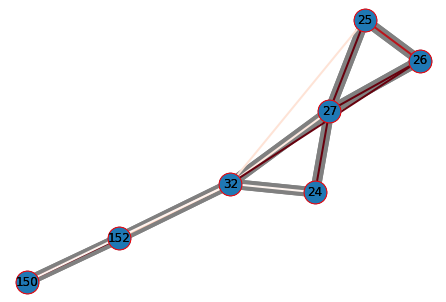

In [19]:
probe_snapshot = 11
hidden_state = torch.zeros(batch_size, num_nodes * hidden_dim).type_as(inputs)
output = None
for i in range(probe_snapshot):
    if i == probe_snapshot - 1:
        dest_model = models.tgcn.TGCNCell_clone(adj, input_dim, hidden_dim, hidden_state)
        dest_model.eval()    
        clone_layers = []
        for item in source_task.model.tgcn_cell._modules.items():
            clone_layers.append(item[0])

        for layer in clone_layers:
            if hasattr(getattr(dest_model, layer), 'weights'):
                with torch.no_grad():
                    getattr(dest_model, layer).weights.copy_(getattr(source_model, layer).weights)
            if hasattr(getattr(dest_model, layer), 'biases'):
                with torch.no_grad():
                    getattr(dest_model, layer).biases.copy_(getattr(source_model, layer).biases)
    
#         dest_output, dest_hidden_state = dest_model.forward(inputs[:, i, :])
#         dest_output = dest_output.reshape((batch_size, num_nodes, hidden_dim))
#         dest_prediction = dest_task.forward(dest_output)
#         source_output =  source_task.model(inputs[:,:i+1, :])
#         source_prediction = source_task.forward(inputs[:,:i+1, :])
    
    output, hidden_state = source_model(inputs[:, i, :], hidden_state)  # First compute the hidden_state before t = seq_len to initializa the dest_model
    
input_features = inputs[:, probe_snapshot-1, :]
# Init
explainer = Node_Explainer(dest_model, dest_task, adj, input_features[0], 0, 2)
# Explain
pgm_nodes, data, pgm_stats = explainer.explain_tgcn_node(TARGET_NODE, 0.001, 0.5, 500, 0.01)
print(pgm_nodes)

from pgmpy.estimators import HillClimbSearch, BicScore


print("Generate the PGM")
pgm_explanation = explainer.pgm_generate(TARGET_NODE, data, stats, pgm_nodes)
print("PGM Nodes: ", pgm_explanation.nodes())
print("PGM Edges: ", pgm_explanation.edges())

print("Draw subgraph using networkx")

def graph_from_adj(adjacency_matrix):
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)
    return gr

nA = explainer.n_hops_A(2)
node_idx_new, sub_A, sub_X, neighbors = explainer.extract_n_hops_neighbors(nA,TARGET_NODE)
plot_G = graph_from_adj(sub_A)
label_dict = dict(zip(range(len(neighbors.tolist())),neighbors.tolist()))

pos=nx.spring_layout(plot_G)

nx.draw(plot_G, pos=pos, node_size=500, labels=label_dict, with_labels=True, width = 10, edge_color = 'gray')

# edge_strength = {}
# for u,v in pgm_explanation.edges(): 

#     node_list_rm_target = [node for node in pgm_explanation.nodes() if node!= str(TARGET_NODE)] 
#     s = explainer.pgm_conditional_prob(v, pgm_explanation,node_list_rm_target)
#     node_list_rm_u = [node for node in pgm_explanation.nodes() if( node!= str(TARGET_NODE) and node!= v and node !=u )]
#     su = explainer.pgm_conditional_prob(v, pgm_explanation,node_list_rm_u)
#     edge_strength[(u,v)] = su - s
edge_strength = {}
    
for u,v in pgm_explanation.edges(): 

    node_list_rm_v = [node for node in pgm_explanation.nodes() if node!= v]
    s = explainer.pgm_conditional_prob(v, pgm_explanation,node_list_rm_v)
    node_list_rm_u = [node for node in pgm_explanation.nodes() if( node!= v and node !=u )]
    su = explainer.pgm_conditional_prob(v, pgm_explanation,node_list_rm_u)
    edge_strength[(u,v)] = su - s
    
edge_weight = {}
for plot_edge in list(plot_G.edges()):
    edge_key = (str(label_dict[plot_edge[0]]),str(label_dict[plot_edge[1]]))
    plot_key = (plot_edge[0],plot_edge[1])
    edge_weight[plot_key] = 0
    if edge_key in edge_strength.keys():
        edge_weight[plot_key] = edge_strength[edge_key]
    edge_key_rev = (str(label_dict[plot_edge[1]]),str(label_dict[plot_edge[0]]))
    if edge_key_rev in edge_strength.keys():
        edge_weight[plot_key] = edge_strength[edge_key_rev]

inv_label_dict = dict(zip(neighbors.tolist(),range(len(neighbors.tolist()))))

pgm_only_edges = []

for edge_key in edge_strength.keys():
    plot_key = (inv_label_dict[int(edge_key[0])], inv_label_dict[int(edge_key[1])])
    rev_plot_key = (inv_label_dict[int(edge_key[1])], inv_label_dict[int(edge_key[0])])
    if plot_key not in list(plot_G.edges()):
        if rev_plot_key not in list(plot_G.edges()):
            pgm_only_edges.append(plot_key)
            edge_weight[plot_key] = edge_strength[edge_key]
            
            
nx.draw(plot_G, pos=pos, node_size=500, labels=label_dict, with_labels=True, width = 10, edge_color = 'gray')

edges = nx.draw_networkx_edges(plot_G,
                               pos=pos,
                               edgelist = plot_G.edges(),
                               edge_color=[edge_weight[e] for e in plot_G.edges()],
                               edge_cmap= plt.cm.Reds,
                               alpha=1.0,
                               width = 2)

nodes = nx.draw_networkx_nodes(plot_G, pos, node_size=520)
nodes.set_edgecolor('red')

edges = nx.draw_networkx_edges(plot_G,
                               pos=pos,
                               edgelist =pgm_only_edges,
                               edge_color=[edge_weight[e] for e in pgm_only_edges],
                               edge_cmap= plt.cm.Reds,
                               alpha=1.0,
                               width = 2)

In [20]:
import sklearn, math,csv
import matplotlib.ticker as mticker
d = ['{0:02d}:{1:02d}'.format(int((i*15)/60), (i*15)%60) for i in range(96)]
# helper function for the formatter
def listifed_formatter(x, pos=None):
    try:
        return d[int(x)]
    except IndexError:
        return ''
mt = mticker.FuncFormatter(listifed_formatter)

valdata = dm.val_dataloader()
pred_result = []
for i, (valfeature, labels) in enumerate(valdata):
    prediction = task.forward(valfeature)
    prediction = prediction.reshape(-1, prediction.shape[2])
    prediction = prediction.detach().numpy()
    pred_result.append([prediction[:,0]])
    
pred_result.append([prediction[:,1]])
pred_result.append([prediction[:,2]])
pred_result = np.array(pred_result)
pred_result = pred_result.reshape(-1,pred_result.shape[2])
pred_result = pred_result*task.feat_max_val
print(pred_result.shape)


speed = []
with open('data/sz_speed.csv','r') as speedfile:
    lines = csv.reader(speedfile)
    next(lines)
    for row in lines:
        speed.append(row)
speed = np.array(speed)
speed = speed.astype(float)
x = np.arange(2976)
total_time = speed.shape[0]
val_speed = speed[(total_time - 581):, :]
#print(val_speed.shape)
val_speed = val_speed / np.max(val_speed)

(583, 156)


In [21]:
def find2hop_neigh(index, adj):
    neighbor = []
    first_hop = np.ravel(np.nonzero(adj[index]))
    for i in first_hop:        
        second_hop = np.ravel(np.nonzero(adj[i]))
        for j in second_hop:
            if( (neighbor.count(j) == 0) and (first_hop.tolist().count(j)==0) and j!= index):
                neighbor.append(j)
    return neighbor

firhop_str = []
sechop_str = []
first_hop = np.ravel(np.nonzero(adj[TARGET_NODE]))
second_hop = find2hop_neigh(TARGET_NODE, adj)
for i in range(len(first_hop)):
    firhop_str.append([])
    
for i in range(len(second_hop)):
    sechop_str.append([])

In [12]:
threshold = 581 

samples = threshold - 96

for val_features, val_labels in dm.val_dataloader():
    samples = samples + 1
    print(samples)
    if samples > threshold:
        break
        
    inputs = val_features
    batch_size, seq_len, num_nodes = inputs.shape
    assert input_dim == num_nodes
    
    dependent_neighbors = []
    for probe_snapshot in range(11,12):

        hidden_state = torch.zeros(batch_size, num_nodes * hidden_dim).type_as(inputs)
        output = None
        for i in range(probe_snapshot):
            if i == probe_snapshot - 1:
                dest_model = models.tgcn.TGCNCell_clone(adj, input_dim, hidden_dim, hidden_state)
                dest_model.eval()    
                clone_layers = []
                for item in source_task.model.tgcn_cell._modules.items():
                    clone_layers.append(item[0])

                for layer in clone_layers:
                    if hasattr(getattr(dest_model, layer), 'weights'):
                        with torch.no_grad():
                            getattr(dest_model, layer).weights.copy_(getattr(source_model, layer).weights)
                    if hasattr(getattr(dest_model, layer), 'biases'):
                        with torch.no_grad():
                            getattr(dest_model, layer).biases.copy_(getattr(source_model, layer).biases)

            output, hidden_state = source_model(inputs[:, i, :], hidden_state) 

        input_features = inputs[:, probe_snapshot-1, :]
        # Init
        explainer = Node_Explainer(dest_model, dest_task, adj, input_features[0], 0, 2)
        # Explain
        pgm_nodes, data, pgm_stats = explainer.explain_tgcn_node(TARGET_NODE, 0.001, 0.5, 500, 0.01)

        print("Generate the PGM")
        pgm_explanation = explainer.pgm_generate(TARGET_NODE, data, stats, pgm_nodes)
        
#         tem_nodes = []
#         for nodes in pgm_explanation.nodes():
#             tem_nodes.append(nodes)
        
#         print("PGM Nodes: ", pgm_explanation.nodes())
#         print("PGM Edges: ", pgm_explanation.edges())

        
        edge_strength = {}
            
        for u,v in pgm_explanation.edges(): 

            node_list_rm_v = [node for node in pgm_explanation.nodes() if node!= v]
            s = explainer.pgm_conditional_prob(v, pgm_explanation,node_list_rm_v)
            node_list_rm_u = [node for node in pgm_explanation.nodes() if( node!= v and node !=u )]
            su = explainer.pgm_conditional_prob(v, pgm_explanation,node_list_rm_u)
            edge_strength[(u,v)] = su - s

 
        edge_weight = {}
        for plot_edge in list(plot_G.edges()):
            edge_key = (str(label_dict[plot_edge[0]]),str(label_dict[plot_edge[1]]))
            plot_key = (plot_edge[0],plot_edge[1])
            edge_weight[plot_key] = 0
            if edge_key in edge_strength.keys():
                edge_weight[plot_key] = edge_strength[edge_key]
            edge_key_rev = (str(label_dict[plot_edge[1]]),str(label_dict[plot_edge[0]]))
            if edge_key_rev in edge_strength.keys():
                edge_weight[plot_key] = edge_strength[edge_key_rev]

        pgm_only_edges = []

        for edge_key in edge_strength.keys():
            plot_key = (inv_label_dict[int(edge_key[0])], inv_label_dict[int(edge_key[1])])
            rev_plot_key = (inv_label_dict[int(edge_key[1])], inv_label_dict[int(edge_key[0])])
            if plot_key not in list(plot_G.edges()):
                if rev_plot_key not in list(plot_G.edges()):
                    pgm_only_edges.append(plot_key)
                    edge_weight[plot_key] = edge_strength[edge_key]
        
        file_name = 'edgeweight/node_' + str(TARGET_NODE) + '_v3/edgeweight__' + str(samples) + '.pkl'
        #np.save(file_name,tem_nodes)
        with open(file_name, 'wb') as f:
            pickle.dump(edge_weight, f)
#
         
#        for i in range(len(first_hop)):
#             firsthop_key = (str(TARGET_NODE), str(first_hop[i]))
#             rev_firsthop_key = (str(first_hop[i]), str(TARGET_NODE))
#             if firsthop_key  in edge_strength.keys():
#                 firhop_str[i].append(edge_strength[firsthop_key])
#             if ( rev_firsthop_key in edge_strength.keys()):
#                 firhop_str[i].append(edge_strength[rev_firsthop_key])
#             else:
#                 firhop_str[i].append(0)
                
#         for i in range(len(second_hop)):
#             secondhop_key = (str(TARGET_NODE), str(second_hop[i]))
#             rev_secondhop_key = (str(second_hop[i]), str(TARGET_NODE))
#             if secondhop_key  in edge_strength.keys():
#                 sechop_str[i].append(edge_strength[secondhop_key])
#             if ( rev_secondhop_key in edge_strength.keys()):
#                 sechop_str[i].append(edge_strength[rev_secondhop_key])
#             else:
#                 sechop_str[i].append(0)
            #plt.figure()
    #         print("Draw pgm explaination using networkx")

#         nx.draw(plot_G, pos=pos, node_size=500, labels=label_dict, with_labels=True, width = 10, edge_color = 'gray')

#         edges = nx.draw_networkx_edges(plot_G,
#                                    pos=pos,
#                                    edgelist = plot_G.edges(),
#                                    edge_color=[edge_weight[e] for e in plot_G.edges()],
#                                    edge_cmap= plt.cm.Reds,
#                                    alpha=1.0,
#                                    width = 2)

#         nodes = nx.draw_networkx_nodes(plot_G, pos, node_size=500)
#         nodes.set_edgecolor('red')



#         edges = nx.draw_networkx_edges(plot_G,
#                                        pos=pos,
#                                        edgelist =pgm_only_edges,
#                                        edge_color=[edge_weight[e] for e in pgm_only_edges],
#                                        edge_cmap= plt.cm.Reds,
#                                        alpha=1.0,
#                                        width = 2)

#     #     nx.draw(pgm_explanation, with_labels=True)
#         #plt.show()

#         dependent_neighbors.append(pgm_nodes)

486
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


487
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


488
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


489
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


490
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(
/home/whe2/.local/lib/python3.9/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:466: RuntimeWarning: invalid value encountered in true_divide
  phi.values = phi.values / phi.values.sum()


491
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


492
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


493
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


494
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


495
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


496
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


497
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


498
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


499
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


500
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


501
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


502
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


503
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


504
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


505
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


506
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


507
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


508
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


509
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


510
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


511
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


512
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


513
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


514
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


515
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


516
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


517
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


518
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


519
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


520
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


521
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


522
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


523
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


524
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


525
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


526
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


527
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


528
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


529
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


530
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


531
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


532
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


533
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


534
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


535
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


536
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


537
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


538
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


539
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


540
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


541
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


542
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


543
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


544
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


545
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


546
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


547
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


548
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


549
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


550
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


551
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


552
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


553
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


554
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


555
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


556
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


557
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


558
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


559
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


560
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


561
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


562
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


563
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


564
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


565
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


566
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


567
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


568
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


569
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


570
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


571
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


572
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


573
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


574
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


575
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


576
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


577
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


578
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


579
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


580
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


581
Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/whe2/.local/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


582


In [22]:
edgeweight_list = []
threshold = 581
samples = threshold - 96 + 1#11 + 96*2 + 1

for i in range(samples, threshold + 1):
    file_name = 'edgeweight/node_' + str(TARGET_NODE) + '_v2/edgeweight__' + str(i) + '.pkl'
    with open(file_name, 'rb') as f:
        loaded_dict = pickle.load(f)
        new_dict = {}
        for keys_val in loaded_dict.keys():
            edges = (label_dict[keys_val[0]], label_dict[keys_val[1]])
            new_dict[edges] = loaded_dict[keys_val]
        edgeweight_list.append(new_dict)

edgeweight_list_v3 = []
        
for i in range(samples, threshold + 1):
    file_name = 'edgeweight/node_' + str(TARGET_NODE) + '_v3/edgeweight__' + str(i) + '.pkl'
    with open(file_name, 'rb') as f:
        loaded_dict = pickle.load(f)
        new_dict = {}
        for keys_val in loaded_dict.keys():
            edges = (label_dict[keys_val[0]], label_dict[keys_val[1]])
            new_dict[edges] = loaded_dict[keys_val]
        edgeweight_list_v3.append(new_dict)

In [23]:
least_value = -5

# first_hop = [12, 126, 93, 134, 133]
# second_hop = [91, 45, 151, 120, 96, 145]
# firsthop_list = [[],[],[],[],[]]
# secondhop_list = [[],[],[],[],[],[]]
first_hop = [24, 27, 152]
second_hop = [150, 25,25]
firsthop_list = [[],[],[]]
secondhop_list = [[],[],[]]

#strength_th = 0.7
for edgeweight in edgeweight_list:
    #print(nodes)
    #first_sum = 0
    #second_sum = 0
    for i in range(len(first_hop)): 
        node = first_hop[i]
        key = (node, TARGET_NODE)
        rev_key = (TARGET_NODE, node)
        if (key in edgeweight):
            firsthop_list[i].append(edgeweight[key])
        elif (rev_key in edgeweight):
            firsthop_list[i].append(edgeweight[rev_key])
        else:
            firsthop_list[i].append(least_value)
    for i in range(len(second_hop)): 
        node = second_hop[i]
        key = (node, TARGET_NODE)
        rev_key = (TARGET_NODE, node)
        if (key in edgeweight):
            secondhop_list[i].append(edgeweight[key])
        elif (rev_key in edgeweight):
            secondhop_list[i].append(edgeweight[rev_key])
        else:
            secondhop_list[i].append(least_value)

In [24]:
firsthop_list_v3 = [[],[],[]]
secondhop_list_v3 = [[],[],[]]
for edgeweight in edgeweight_list_v3:
    #print(nodes)
    #first_sum = 0
    #second_sum = 0
    for i in range(len(first_hop)): 
        node = first_hop[i]
        key = (node, TARGET_NODE)
        rev_key = (TARGET_NODE, node)
        if (key in edgeweight):
            firsthop_list_v3[i].append(edgeweight[key])
        elif (rev_key in edgeweight):
            firsthop_list_v3[i].append(edgeweight[rev_key])
        else:
            firsthop_list_v3[i].append(least_value)
    for i in range(len(second_hop)): 
        node = second_hop[i]
        key = (node, TARGET_NODE)
        rev_key = (TARGET_NODE, node)
        if (key in edgeweight):
            secondhop_list_v3[i].append(edgeweight[key])
        elif (rev_key in edgeweight):
            secondhop_list_v3[i].append(edgeweight[rev_key])
        else:
            secondhop_list_v3[i].append(least_value)

first hop neighbor:  [ 24  27 152]
neighbor:  24
neighbor:  27
neighbor:  152


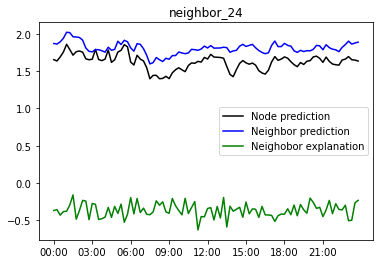

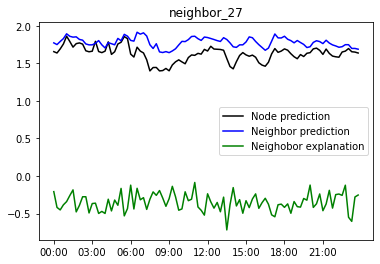

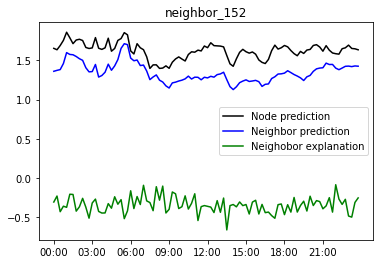

In [25]:
total_time = speed.shape[0]
t = 5
#pred_time = pred_result.shape[0]
end = 581#96*(t + 1) + 12
start = 581- 96 + 1#96*t + 11 
one_day = 96
nodes = [TARGET_NODE]
for i in nodes:
    print("first hop neighbor: ",np.ravel(np.nonzero(adj[i])) )
    count = 0
    
    for j in np.ravel(np.nonzero(adj[i])):
        print("neighbor: ", j)
        fig, ax = plt.subplots()
        label_name = 'neighbor_' + str(j)
        ax.plot( pred_result[(start) : end + 1,i]/20 , color = 'black', label = 'Node prediction')
        ax.plot( pred_result[(start) : end + 1,j]/20 , color = 'b', label = 'Neighbor prediction')    
        ax.plot( (np.array(firsthop_list[count]) + np.array(firsthop_list_v3[count]) / 2.0 ) , color = 'g', label = 'Neighobor explanation')
        #ax.plot( val_speed[start :end,j], color = 'r', label = 'neighbor groundtruth')
        #ax.plot( firhop_str[count,start:end], color = 'black', label = 'edge strength')
#         ax.plot( pred_result[(pred_time - one_day) :,j], color = 'b', label = 'neighbor prediction')
        ax.legend()
        ax.xaxis.set_major_formatter(mt)        
        fname = 'explain_figure/node_' +str(i)  + '/neighobor_' + str(j) + '.png'
        count = count + 1
        plt.title(label_name)
        plt.xticks(np.arange(0, 96, 12))
        plt.savefig(fname)
        
    

second hop neighbor:  [25, 26, 150]
neighbor:  25
neighbor:  26
neighbor:  150


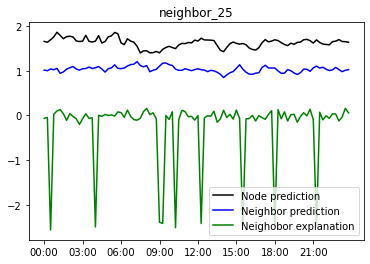

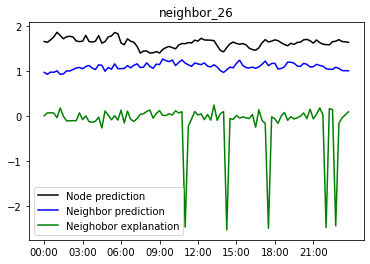

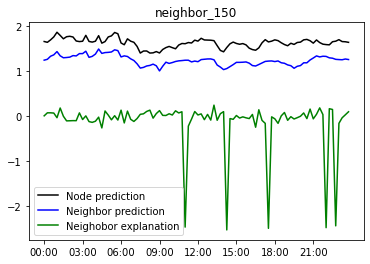

In [27]:
total_time = speed.shape[0]
t = 5
#pred_time = pred_result.shape[0]
end = 581#96*(t + 1) + 12
start = 581- 96 + 1#96*t + 11 
one_day = 96
nodes = [TARGET_NODE]
for i in nodes:
    print("second hop neighbor: ",find2hop_neigh(TARGET_NODE, adj) )
    count = 0
    
    for j in find2hop_neigh(TARGET_NODE, adj):
        print("neighbor: ", j)
        fig, ax = plt.subplots()
        label_name = 'neighbor_' + str(j)
        
        ax.plot( pred_result[(start) : end + 1,i]/20 , color = 'black', label = 'Node prediction')
        ax.plot( pred_result[(start) : end + 1,j]/20 , color = 'b', label = 'Neighbor prediction')    
        ax.plot( (np.array(secondhop_list[count]) + np.array(secondhop_list_v3[count])) / 2.0, color = 'g', label = 'Neighobor explanation')
        #ax.plot( val_speed[start :end,j], color = 'r', label = 'neighbor groundtruth')
        #ax.plot( firhop_str[count,start:end], color = 'black', label = 'edge strength')
#         ax.plot( pred_result[(pred_time - one_day) :,j], color = 'b', label = 'neighbor prediction')
        ax.legend()
        ax.xaxis.set_major_formatter(mt)        
        fname = 'explain_figure/node_' +str(i)  + '_v2/neighobor_' + str(j) + '.png'
        count = count + 1
        plt.xticks(np.arange(0, 96, 12))
        plt.title(label_name)
        plt.savefig(fname)
        
    

In [17]:
def checkKey(diction, key, threshold):
    newkey = (int(key[0]), int(key[1]))
    rev_newkey = (int(key[1]), int(key[0]))
    if newkey in diction.keys() and diction[newkey] > threshold:
        return True  
    elif rev_newkey in diction.keys() and diction[rev_newkey] > threshold:
        return True
    else:
        return False

oneedge_graph = [('93', '125'), ('133', '125'),('134','125'), ('12', '125'), ('126', '125'),
                 ('45', '125'), ('145', '125'), ('120', '125'), ('151', '125'),
                 ('91', '45'), ('93', '91'), ('93', '133'),  ('96', '145'),
                 ('126', '12'), ('133', '120')]


In [11]:
edgeweight_list = []
samples = 11 + 96*2 + 1
threshold = 581
for i in range(samples, threshold + 1):
    file_name = 'edgeweight/edgeweight_' + str(i) + '.pkl'
    with open(file_name, 'rb') as f:
        loaded_dict = pickle.load(f)
        new_dict = {}
        for keys_val in loaded_dict.keys():
            edges = (label_dict[keys_val[0]], label_dict[keys_val[1]])
            new_dict[edges] = loaded_dict[keys_val]
        edgeweight_list.append(new_dict)



In [37]:
edgeweight_list

[{(12, 125): 0,
  (12, 126): 0.020000000000000018,
  (125, 93): 0.76,
  (125, 126): 0,
  (125, 133): 0.8200000000000001,
  (125, 134): 0.8,
  (45, 91): 0.10000000000000009,
  (45, 93): 0,
  (91, 93): 0,
  (93, 133): 0,
  (93, 134): 0,
  (133, 120): 0.0,
  (133, 134): 0,
  (133, 151): 0,
  (134, 96): 0.020000000000000018,
  (134, 145): 0,
  (96, 145): 0,
  (120, 151): 0.040000000000000036,
  (45, 125): 0.8200000000000001,
  (120, 125): 0.84},
 {(12, 125): 0,
  (12, 126): 0.07999999999999996,
  (125, 93): 0.74,
  (125, 126): 0,
  (125, 133): 0.72,
  (125, 134): 0.74,
  (45, 91): 0.040000000000000036,
  (45, 93): 0.020000000000000018,
  (91, 93): 0,
  (93, 133): 0,
  (93, 134): 0,
  (133, 120): 0.1200000000000001,
  (133, 134): 0,
  (133, 151): 0,
  (134, 96): 0,
  (134, 145): 0.040000000000000036,
  (96, 145): 0.09999999999999998,
  (120, 151): 0.0,
  (45, 125): 0.8,
  (120, 125): 0.8200000000000001,
  (151, 125): 0.8200000000000001},
 {(12, 125): 0,
  (12, 126): 0.040000000000000036,
  

One node frequent graph mining

In [18]:
threshold = 0.5
edge_freq_dict = {}
for edge_graph in oneedge_graph: 
    edge_freq_dict[edge_graph] = 0
for edge_weight in edgeweight_list: 
    for edge_graph in oneedge_graph: 
        if checkKey(edge_weight, edge_graph, threshold):
            edge_freq_dict[edge_graph] = edge_freq_dict[edge_graph] + 1
            

In [19]:
for keys in edge_freq_dict.keys():
    edge_freq_dict[keys] = edge_freq_dict[keys] /(581 - samples + 1)

In [20]:
edge_freq_dict

{('93', '125'): 0.4375,
 ('133', '125'): 0.5,
 ('134', '125'): 0.59375,
 ('12', '125'): 0.0,
 ('126', '125'): 0.5833333333333334,
 ('45', '125'): 0.6666666666666666,
 ('145', '125'): 0.5729166666666666,
 ('120', '125'): 0.5104166666666666,
 ('151', '125'): 0.53125,
 ('91', '45'): 0.0,
 ('93', '91'): 0.0,
 ('93', '133'): 0.0,
 ('96', '145'): 0.0,
 ('126', '12'): 0.0,
 ('133', '120'): 0.0}

In [21]:
plot_G

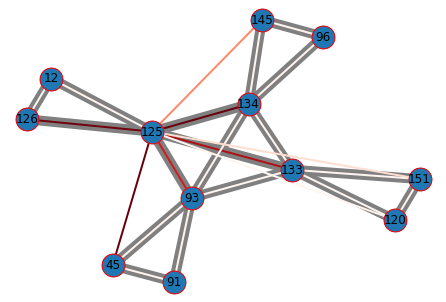

In [22]:
edge_weight = {}
for plot_edge in list(plot_G.edges()):
    edge_key = (str(label_dict[plot_edge[0]]),str(label_dict[plot_edge[1]]))
    plot_key = (plot_edge[0],plot_edge[1])
    edge_weight[plot_key] = 0
    if edge_key in edge_freq_dict.keys():
        edge_weight[plot_key] = edge_freq_dict[edge_key]
    edge_key_rev = (str(label_dict[plot_edge[1]]),str(label_dict[plot_edge[0]]))
    if edge_key_rev in edge_freq_dict.keys():
        edge_weight[plot_key] = edge_freq_dict[edge_key_rev]

inv_label_dict = dict(zip(neighbors.tolist(),range(len(neighbors.tolist()))))

pgm_only_edges = []

for edge_key in edge_freq_dict.keys():
    plot_key = (inv_label_dict[int(edge_key[0])], inv_label_dict[int(edge_key[1])])
    rev_plot_key = (inv_label_dict[int(edge_key[1])], inv_label_dict[int(edge_key[0])])
    if plot_key not in list(plot_G.edges()):
        if rev_plot_key not in list(plot_G.edges()):
            pgm_only_edges.append(plot_key)
            edge_weight[plot_key] = edge_freq_dict[edge_key]

nx.draw(plot_G, pos=pos, node_size=500, labels=label_dict, with_labels=True, width = 10, edge_color = 'gray')

edges = nx.draw_networkx_edges(plot_G,
                               pos=pos,
                               edgelist = plot_G.edges(),
                               edge_color=[edge_weight[e] for e in plot_G.edges()],
                               edge_cmap= plt.cm.Reds,
                               alpha=1.0,
                               width = 2)

nodes = nx.draw_networkx_nodes(plot_G, pos, node_size=520)
nodes.set_edgecolor('red')

edges = nx.draw_networkx_edges(plot_G,
                               pos=pos,
                               edgelist =pgm_only_edges,
                               edge_color=[edge_weight[e] for e in pgm_only_edges],
                               edge_cmap= plt.cm.Reds,
                               alpha=1.0,
                               width = 2)

In [25]:
two_edge_graph = [('93', '125'), ('133', '125'),('134','125'), ('126', '125'),
                 ('45', '125'), ('145', '125'), ('120', '125'), ('151', '125'),
                 ]
def checkKey_twoEdge(diction, keys, threshold):
    key = (int(keys[0]), int(keys[1]))
    rev_key = (int(keys[1]), int(keys[0]))
    key_two = (int(keys[2]), int(keys[3]))
    rev_key_two = (int(keys[3]), int(keys[2]))
    condition1 = key in diction.keys() and diction[key] > threshold
    condition2 = rev_key in diction.keys() and diction[rev_key] > threshold
    condition3 = key_two in diction.keys() and diction[key_two] > threshold
    condition4 = rev_key_two in diction.keys() and diction[rev_key_two] > threshold

    if condition1 and condition3:
        return True  
    elif condition1 and condition4:
        return True
    elif condition2 and condition3:
        return True
    elif condition2 and condition4:
        return True
    else:
        return False


In [26]:
two_edge_freq_dict = {}
for i in range(len(two_edge_graph)): 
    for j in range(i+1, len(two_edge_graph)):
        edge_one = two_edge_graph[i]
        edge_two = two_edge_graph[j]
        if edge_one == edge_two:
                break;
        keys = (edge_one[0], edge_one[1], edge_two[0], edge_two[1])
        two_edge_freq_dict[keys] = 0
for edge_weight in edgeweight_list: 
    for i in range(len(two_edge_graph)): 
        for j in range(i+1, len(two_edge_graph)):
            edge_one = two_edge_graph[i]
            edge_two = two_edge_graph[j]
            if edge_one == edge_two:
                break;
            keys = (edge_one[0], edge_one[1], edge_two[0], edge_two[1])
            if checkKey_twoEdge(edge_weight, keys, threshold):
                two_edge_freq_dict[keys] = two_edge_freq_dict[keys] + 1


In [27]:
for keys in two_edge_freq_dict.keys():
    two_edge_freq_dict[keys] = two_edge_freq_dict[keys] /(581 - samples + 1)

In [28]:
threshold

0.5

In [29]:
three_edge_graph = [('93', '125', '133', '125'), ('93', '125', '45', '125'),('93','125','145', '125'), ('93', '125','120','125'),
                 ('45', '125','133', '125'), ('145', '125', '133','125'), ('120', '125','133', '125'), ('134', '125','45','125'),
                 ('134','125','126','125'), ('126', '125', '45', '125'), ('45','125', '145','125'), ('45','125', '120','125'),('45','125','151','125'),
                   ('145','125','120','125')]
def checkKey_threeEdge(diction, keys, threshold):
    key1 = (int(keys[0]), int(keys[1]))
    rev_key1 = (int(keys[1]), int(keys[0]))
    key2 = (int(keys[2]), int(keys[3]))
    rev_key2 = (int(keys[3]), int(keys[2]))
    key3 = (int(keys[4]), int(keys[5]))
    rev_key3 = (int(keys[5]), int(keys[4]))
    
    condition1 = key1 in diction.keys() and diction[key1] > threshold
    condition2 = rev_key1 in diction.keys() and diction[rev_key1] > threshold
    condition3 = key2 in diction.keys() and diction[key2] > threshold
    condition4 = rev_key2 in diction.keys() and diction[rev_key2] > threshold
    condition5 = key3 in diction.keys() and diction[key3] > threshold
    condition6 = rev_key3 in diction.keys() and diction[rev_key3] > threshold

    if condition1 and condition3 and condition5:
        return True  
    elif condition1 and condition3 and condition6:
        return True  
    elif condition1 and condition4 and condition5:
        return True
    elif condition1 and condition4 and condition6:
        return True
    elif condition2 and condition3 and condition5:
        return True
    elif condition2 and condition3 and condition6:
        return True
    elif condition2 and condition4 and condition5:
        return True
    elif condition2 and condition4 and condition6:
        return True
    else:
        return False

In [30]:
three_edge_freq_dict = {}
for i in range(len(three_edge_graph)): 
    for j in range(i+1, len(two_edge_graph)):
        edge_one = three_edge_graph[i]
        edge_two = two_edge_graph[j]
        keys1 = (edge_one[0], edge_one[1])
        keys2 = (edge_one[2],edge_one[3])
        if keys1 == edge_two or keys2 == edge_two:
                break;
        keys = (edge_one[0], edge_one[1],edge_one[2],edge_one[3], edge_two[0], edge_two[1])
        three_edge_freq_dict[keys] = 0
for edge_weight in edgeweight_list: 
    for i in range(len(three_edge_graph)): 
        for j in range(i+1, len(two_edge_graph)):
            edge_one = three_edge_graph[i]
            edge_two = two_edge_graph[j]
            keys1 = (edge_one[0], edge_one[1])
            keys2 = (edge_one[2],edge_one[3])
            if keys1 == edge_two or keys2 == edge_two:
                    break;
            keys = (edge_one[0], edge_one[1],edge_one[2],edge_one[3], edge_two[0], edge_two[1])
            if checkKey_threeEdge(edge_weight, keys, threshold):
                three_edge_freq_dict[keys] = three_edge_freq_dict[keys] + 1


In [31]:
for keys in three_edge_freq_dict.keys():
    three_edge_freq_dict[keys] = three_edge_freq_dict[keys] /(581 - samples + 1)

In [32]:
three_edge_freq_dict

{('93', '125', '45', '125', '134', '125'): 0.14583333333333334,
 ('93', '125', '45', '125', '126', '125'): 0.08333333333333333,
 ('93', '125', '145', '125', '126', '125'): 0.07291666666666667,
 ('93', '125', '145', '125', '45', '125'): 0.28125,
 ('93', '125', '120', '125', '45', '125'): 0.2916666666666667,
 ('93', '125', '120', '125', '145', '125'): 0.2604166666666667,
 ('45', '125', '133', '125', '145', '125'): 0.3020833333333333,
 ('45', '125', '133', '125', '120', '125'): 0.25,
 ('45', '125', '133', '125', '151', '125'): 0.09375,
 ('145', '125', '133', '125', '120', '125'): 0.2708333333333333,
 ('145', '125', '133', '125', '151', '125'): 0.11458333333333333,
 ('120', '125', '133', '125', '151', '125'): 0.08333333333333333}

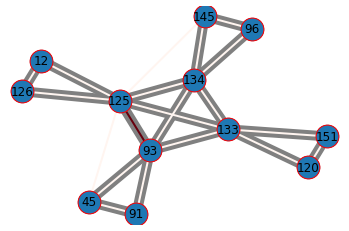

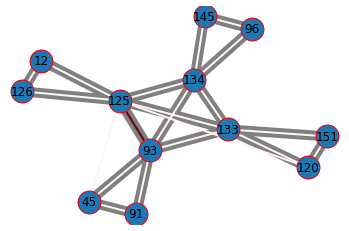

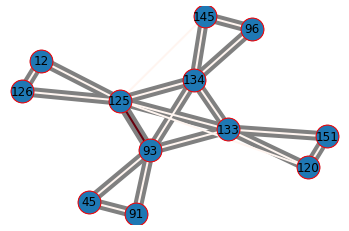

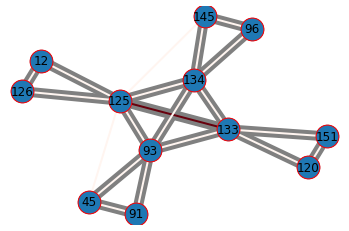

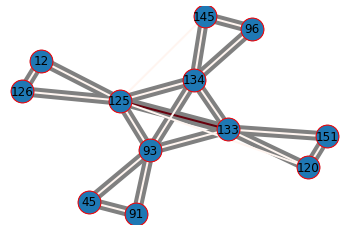

In [36]:
threshold_three = 0.25
for keys in three_edge_freq_dict.keys():
    if three_edge_freq_dict[keys] > threshold_three:
        edge_freq_dict = {}
        edge_freq_dict[(keys[0], keys[1])] = 1
        edge_freq_dict[(keys[2], keys[3])] = 1
        edge_freq_dict[(keys[4], keys[5])] = 1
        
        edge_weight = {}
        for plot_edge in list(plot_G.edges()):
            edge_key = (str(label_dict[plot_edge[0]]),str(label_dict[plot_edge[1]]))
            plot_key = (plot_edge[0],plot_edge[1])
            edge_weight[plot_key] = 0
            if edge_key in edge_freq_dict.keys():
                edge_weight[plot_key] = edge_freq_dict[edge_key]
            edge_key_rev = (str(label_dict[plot_edge[1]]),str(label_dict[plot_edge[0]]))
            if edge_key_rev in edge_freq_dict.keys():
                edge_weight[plot_key] = edge_freq_dict[edge_key_rev]

        inv_label_dict = dict(zip(neighbors.tolist(),range(len(neighbors.tolist()))))

        pgm_only_edges = []

        for edge_key in edge_freq_dict.keys():
            plot_key = (inv_label_dict[int(edge_key[0])], inv_label_dict[int(edge_key[1])])
            rev_plot_key = (inv_label_dict[int(edge_key[1])], inv_label_dict[int(edge_key[0])])
            if plot_key not in list(plot_G.edges()):
                if rev_plot_key not in list(plot_G.edges()):
                    pgm_only_edges.append(plot_key)
                    edge_weight[plot_key] = edge_freq_dict[edge_key]
                    
        fig, ax = plt.subplots()

        nx.draw(plot_G, pos=pos, node_size=500, labels=label_dict, with_labels=True, width = 10, edge_color = 'gray')

        edges = nx.draw_networkx_edges(plot_G,
                                       pos=pos,
                                       edgelist = plot_G.edges(),
                                       edge_color=[edge_weight[e] for e in plot_G.edges()],
                                       edge_cmap= plt.cm.Reds,
                                       alpha=1.0,
                                       width = 2)

        nodes = nx.draw_networkx_nodes(plot_G, pos, node_size=520)
        nodes.set_edgecolor('red')

        edges = nx.draw_networkx_edges(plot_G,
                                       pos=pos,
                                       edgelist =pgm_only_edges,
                                       edge_color=[edge_weight[e] for e in pgm_only_edges],
                                       edge_cmap= plt.cm.Reds,
                                       alpha=1.0,
                                       width = 2)


In [8]:
# filename1 = 'firhop_str.npy'
# filename2 = 'sechop_str.npy'
# firhop_str = np.load(filename1)
# sechop_str = np.load(filename2)

In [9]:
# firhop_str = np.array(firhop_str)
# print(firhop_str.shape)
# sechop_str = np.array(sechop_str)
# print(sechop_str.shape)

(5, 581)
(6, 581)


In [11]:
# filename1 = str(TARGET_NODE) + '_firhop_str.npy'
# filename2 = str(TARGET_NODE) + '_sechop_str.npy'
# np.save(filename1, firhop_str)
# np.save(filename2, sechop_str)

One node frequent Bayesian graph 

In [11]:
strength_threshold = 0.5
frequency_score = 0.7
firsthop_neigh = np.ravel(np.nonzero(adj[TARGET_NODE]))
for i in range (len(firsthop_neigh)):
    print(" first hop neighbor is: ",firsthop_neigh[i] )
    neighbor_str = firhop_str[i]
    total_time = len(neighbor_str)
    neighbor_str = neighbor_str[neighbor_str > strength_threshold]
    print("The frequency for this neighbor is: ", len(neighbor_str)/ total_time)

 first hop neighbor is:  12
The frequency for this neighbor is:  0.012048192771084338
 first hop neighbor is:  93
The frequency for this neighbor is:  0.5421686746987951
 first hop neighbor is:  126
The frequency for this neighbor is:  0.5542168674698795
 first hop neighbor is:  133
The frequency for this neighbor is:  0.5869191049913941
 first hop neighbor is:  134
The frequency for this neighbor is:  0.5869191049913941


In [12]:
strength_threshold = 0.5
frequency_score = 0.7
secondhop_neigh = find2hop_neigh(TARGET_NODE, adj)
for i in range (len(secondhop_neigh)):
    print(" second hop neighbor is: ",secondhop_neigh[i] )
    neighbor_str = sechop_str[i]
    total_time = len(neighbor_str)
    neighbor_str = neighbor_str[neighbor_str > strength_threshold]
    print("The frequency for this neighbor is: ", len(neighbor_str)/ total_time)

 second hop neighbor is:  45
The frequency for this neighbor is:  0.685025817555938
 second hop neighbor is:  91
The frequency for this neighbor is:  0.12908777969018934
 second hop neighbor is:  120
The frequency for this neighbor is:  0.4974182444061962
 second hop neighbor is:  151
The frequency for this neighbor is:  0.45611015490533563
 second hop neighbor is:  96
The frequency for this neighbor is:  0.37865748709122204
 second hop neighbor is:  145
The frequency for this neighbor is:  0.5748709122203098


first hop neighbor:  [ 12  93 126 133 134]
neighbor:  12
neighbor:  93
neighbor:  126
neighbor:  133
neighbor:  134


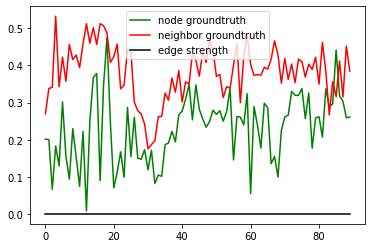

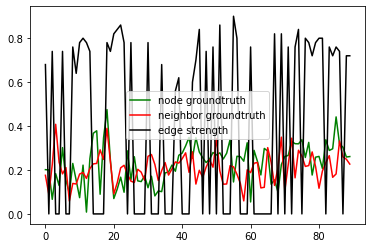

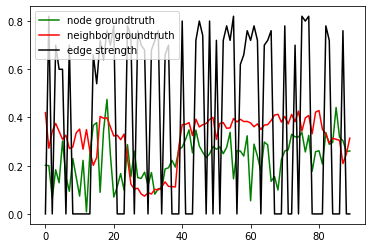

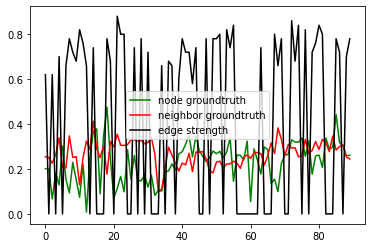

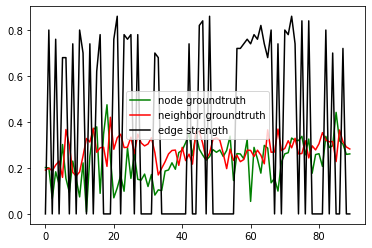

In [12]:
total_time = speed.shape[0]
t = 5
#pred_time = pred_result.shape[0]
start = 96*t + 11 
end = 96*(t + 1) + 12 
nodes = [TARGET_NODE]
for i in nodes:
    print("first hop neighbor: ",np.ravel(np.nonzero(adj[i])) )
    count = 0
    for j in np.ravel(np.nonzero(adj[i])):
        print("neighbor: ", j)
        fig, ax = plt.subplots()
        ax.plot( val_speed[start :end,i], color = 'g', label='node groundtruth')
        ax.plot( val_speed[start :end,j], color = 'r', label = 'neighbor groundtruth')
        ax.plot( firhop_str[count,start:end], color = 'black', label = 'edge strength')
#         ax.plot( pred_result[(pred_time - one_day) :,j], color = 'b', label = 'neighbor prediction')
        ax.legend()
        #ax.xaxis.set_major_formatter(mt)        
        fname = 'figures/node_' +str(i)  + '/neighobor_' + str(j) + '.png'
        count = count + 1
        #plt.savefig(fname)
    #plt.xticks(np.arange(0, len(speed[(total_time - one_day) :,i]), 12))
    

second hop neighbor:  [45, 91, 120, 151, 96, 145]
neighbor:  45
neighbor:  91
neighbor:  120
neighbor:  151
neighbor:  96
neighbor:  145


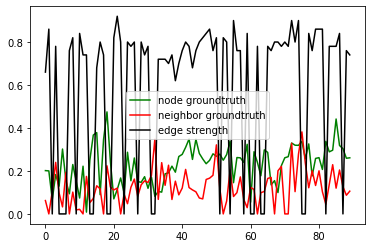

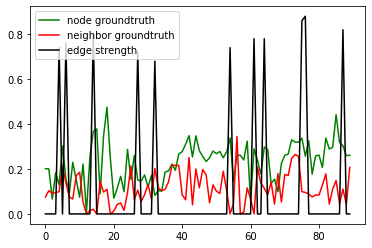

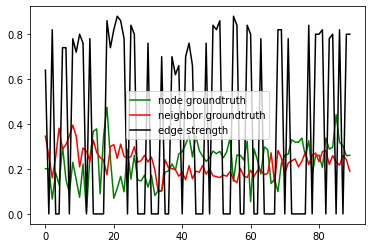

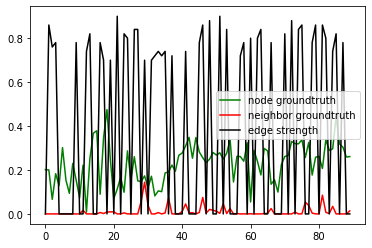

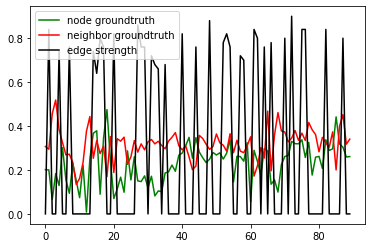

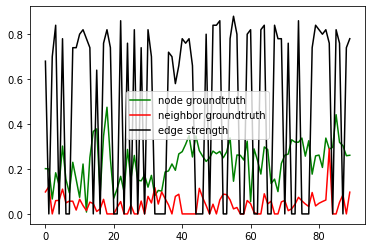

In [13]:
total_time = speed.shape[0]
t = 5
#pred_time = pred_result.shape[0]
start = 96*t + 11 
end = 96*(t + 1) + 12 
nodes = [TARGET_NODE]
for i in nodes:
    print("second hop neighbor: ",find2hop_neigh(TARGET_NODE, adj) )
    count = 0
    for j in find2hop_neigh(TARGET_NODE, adj):
        print("neighbor: ", j)
        fig, ax = plt.subplots()
        ax.plot( val_speed[start :end,i], color = 'g', label='node groundtruth')
        ax.plot( val_speed[start :end,j], color = 'r', label = 'neighbor groundtruth')
        ax.plot( sechop_str[count,start:end], color = 'black', label = 'edge strength')
#         ax.plot( pred_result[(pred_time - one_day) :,j], color = 'b', label = 'neighbor prediction')
        ax.legend()
        #ax.xaxis.set_major_formatter(mt)        
        fname = 'figures/node_' +str(i)  + '/neighobor_' + str(j) + '.png'
        count = count + 1
        #plt.savefig(fname)
    #plt.xticks(np.arange(0, len(speed[(total_time - one_day) :,i]), 12))
    